In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pandas as pd

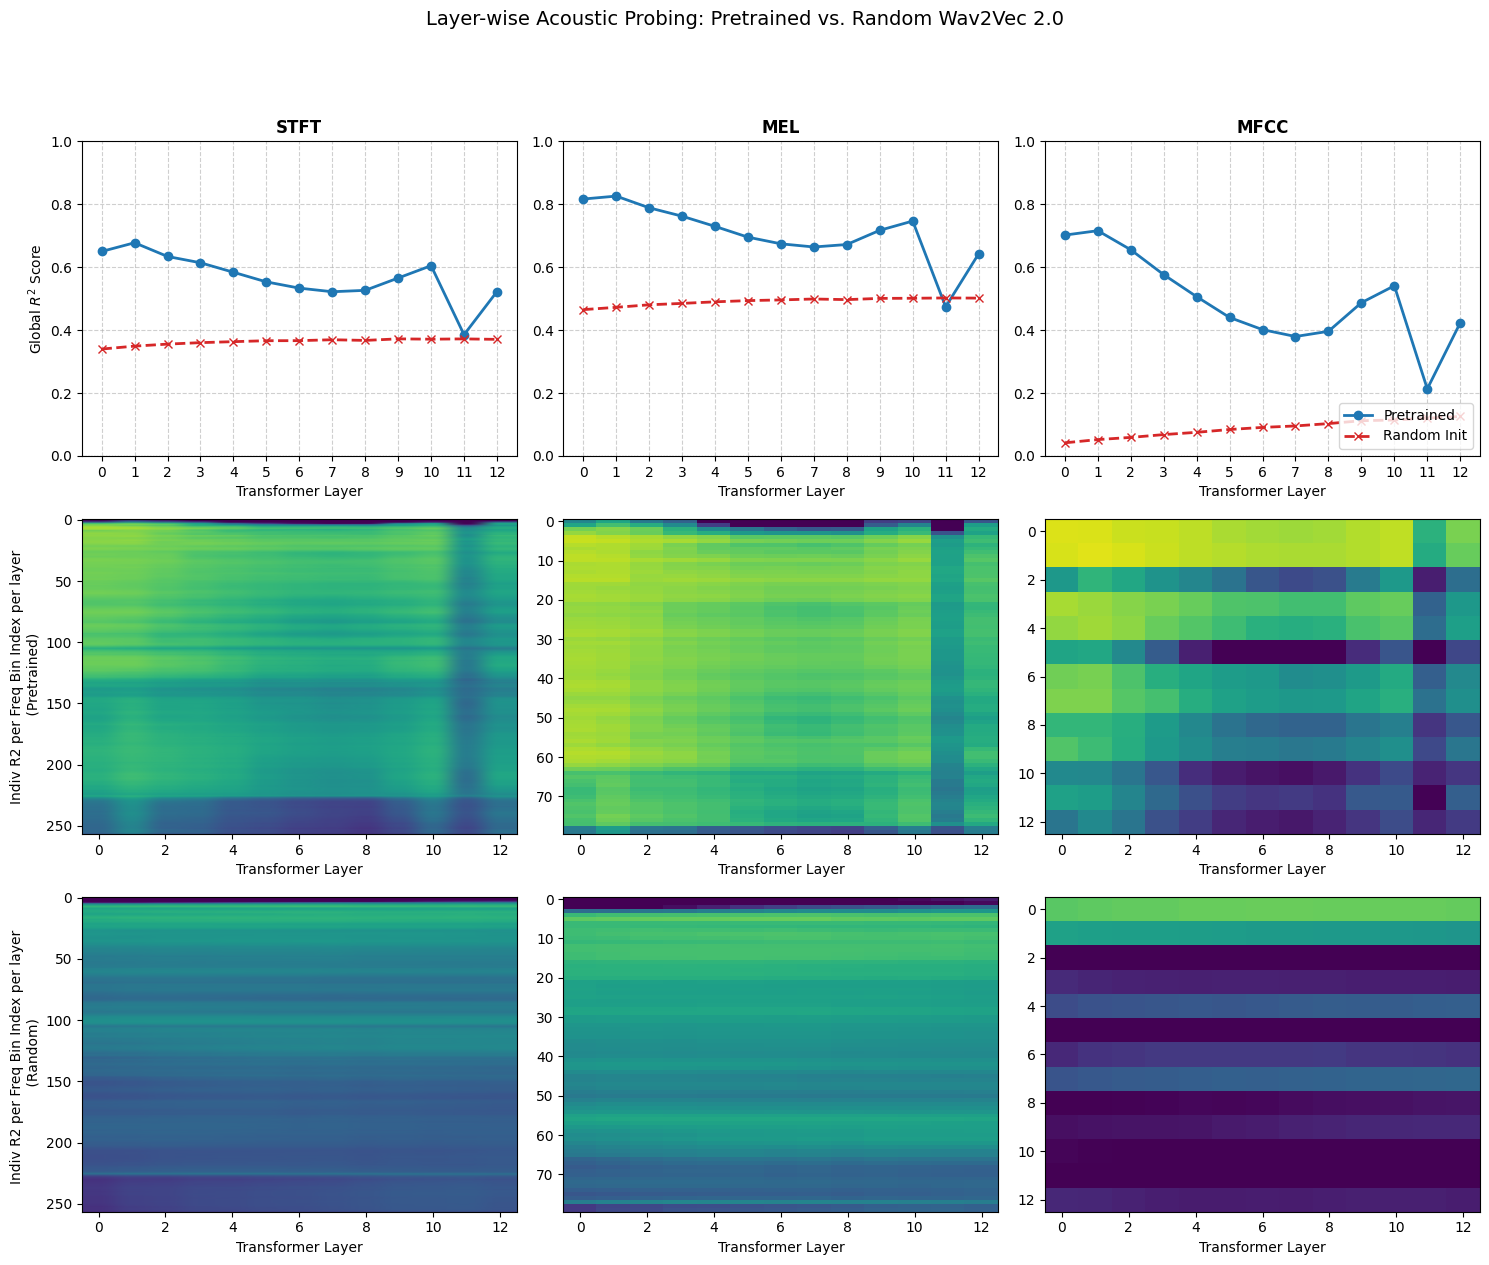

In [125]:
import json
import matplotlib.pyplot as plt

with open("../results/wav2vec2-base_pretrained_ridge/global_r2s.json", "r") as f:
    pretrained_r2 = json.load(f)
with open("../results/wav2vec2-base_random_ridge/global_r2s.json", "r") as f:
    random_r2 = json.load(f)

pretrained_data = {
    "stft": np.load("../results/wav2vec2-base_pretrained_ridge/stft_weights.npz"),
    "mel": np.load("../results/wav2vec2-base_pretrained_ridge/mel_weights.npz"),
    "mfcc": np.load("../results/wav2vec2-base_pretrained_ridge/mfcc_weights.npz"),
}

random_data = {
    "stft": np.load("../results/wav2vec2-base_random_ridge/stft_weights.npz"),
    "mel": np.load("../results/wav2vec2-base_random_ridge/mel_weights.npz"),
    "mfcc": np.load("../results/wav2vec2-base_random_ridge/mfcc_weights.npz"),
}

# The acoustic features we probed
features = ["stft", "mel", "mfcc"]
layers = list(range(13)) 

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Layer-wise Acoustic Probing: Pretrained vs. Random Wav2Vec 2.0", fontsize=14, y=1.05)

for i, feature in enumerate(features):

    ax = axes[0, i]
    pre_scores = [pretrained_r2[feature][f"{l}"] for l in layers]
    rand_scores = [random_r2[feature][f"{l}"] for l in layers]
    ax.plot(layers, pre_scores, marker='o', color='tab:blue', 
            linewidth=2, markersize=6, label='Pretrained')
    ax.plot(layers, rand_scores, marker='x', color='tab:red', 
            linestyle='--', linewidth=2, markersize=6, label='Random Init')
    ax.set_title(feature.upper(), fontsize=12, fontweight='bold')
    ax.set_xlabel("Transformer Layer", fontsize=10)
    ax.set_xticks(layers)
    ax.axhline(0, color='black', linewidth=0.8, linestyle=':')
    ax.grid(True, linestyle='--', alpha=0.6)
    if i == 0:
        ax.set_ylabel("Global $R^2$ Score", fontsize=10)

    ax.set_ylim(0,1)

    ax = axes[1, i]
    r2s = []
    for layer in range(13):
        pre_indiv_r2 = pretrained_data[feature][f'layer_{layer}_r2']  
        r2s.append(pre_indiv_r2)
    ax.imshow(np.array(r2s).T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    if i == 0:
        ax.set_ylabel("Indiv R2 per Freq Bin Index per layer\n (Pretrained)", fontsize=10)
    ax.set_xlabel("Transformer Layer", fontsize=10)

    ax = axes[2, i]
    r2s = []
    for layer in range(13):
        pre_indiv_r2 = random_data[feature][f'layer_{layer}_r2']  
        r2s.append(pre_indiv_r2)
    ax.imshow(np.array(r2s).T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    if i == 0:
        ax.set_ylabel("Indiv R2 per Freq Bin Index per layer \n (Random)", fontsize=10)
    ax.set_xlabel("Transformer Layer", fontsize=10)


axes[0, -1].legend(loc='lower right', frameon=True, fontsize=10)




plt.tight_layout()
plt.show()


In [137]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

# 1. Choose the layer and load BOTH sets of weights
layer_idx = 12
pre_path = "../results/wav2vec2-base_ridge/mel_weights.npz" 
rand_path = "../results/wav2vec2-base_random_ridge/mel_weights.npz" 

pre_data = np.load(pre_path)
rand_data = np.load(rand_path)

W_pre = pre_data[f"layer_{layer_idx}_coefs"]
r2_pre = pre_data[f"layer_{layer_idx}_r2"]

W_rand = rand_data[f"layer_{layer_idx}_coefs"]
r2_rand = rand_data[f"layer_{layer_idx}_r2"]

# 2. Run PCA separately for both models
pca_pre = PCA(n_components=3)
W_pre_pca = pca_pre.fit_transform(W_pre)
print(f"Explained Variance across 3D for Pretrained: {sum(pca_pre.explained_variance_ratio_) * 100:.1f}%")

pca_rand = PCA(n_components=3)
W_rand_pca = pca_rand.fit_transform(W_rand)
print(f"Explained Variance across 3D for Random: {sum(pca_rand.explained_variance_ratio_) * 100:.1f}%")

freq_bins = np.arange(W_pre_pca.shape[0])

# 3. Size scaling (Clipping negative R^2 scores so Plotly doesn't crash)
size_pre = np.clip(r2_pre, 0, 1) * 20 + 2
size_rand = np.clip(r2_rand, 0, 1) * 20 + 2

# 4. Set up the Side-by-Side 3D Figure
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=(
        f"Pretrained Geometry (Layer {layer_idx})", 
        f"Random Baseline (Layer {layer_idx})"
    )
)

# 5. Add the Pretrained Trace (Left)
fig.add_trace(
    go.Scatter3d(
        x=W_pre_pca[:, 0], y=W_pre_pca[:, 1], z=W_pre_pca[:, 2],
        mode='lines+markers',
        marker=dict(size=size_pre, color=freq_bins, colorscale='hsv', opacity=0.9),
        text=[f"Freq Bin: {i}<br>R2: {r:.3f}" for i, r in zip(freq_bins, r2_pre)],
        hoverinfo='text'
    ),
    row=1, col=1
)

# 6. Add the Random Trace (Right)
fig.add_trace(
    go.Scatter3d(
        x=W_rand_pca[:, 0], y=W_rand_pca[:, 1], z=W_rand_pca[:, 2],
        mode='lines+markers',
        marker=dict(size=size_rand, color=freq_bins, colorscale='hsv', opacity=0.9),
        text=[f"Freq Bin: {i}<br>R2: {r:.3f}" for i, r in zip(freq_bins, r2_rand)],
        hoverinfo='text'
    ),
    row=1, col=2
)

# 7. Clean up the layout
fig.update_layout(
    height=700, 
    width=1200, 
    showlegend=False,
    title_text="Latent Acoustic Geometry: Pretrained vs Random Initialization",
    title_x=0.5
)

# Hide axis background panels for a cleaner "floating" look
for i in [1, 2]:
    fig.layout[f'scene{i}'].xaxis.showbackground = False
    fig.layout[f'scene{i}'].yaxis.showbackground = False
    fig.layout[f'scene{i}'].zaxis.showbackground = False

fig.show()

Explained Variance across 3D for Pretrained: 44.8%
Explained Variance across 3D for Random: 67.6%


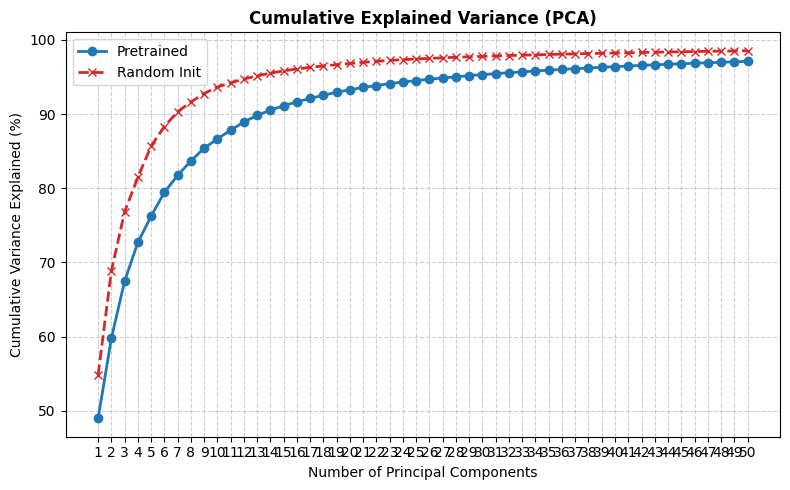

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA for 20 components
n_comps = 50
pca_pre_full = PCA(n_components=n_comps).fit(W_pre)
pca_rand_full = PCA(n_components=n_comps).fit(W_rand)

# Calculate cumulative variance
cum_var_pre = np.cumsum(pca_pre_full.explained_variance_ratio_) * 100
cum_var_rand = np.cumsum(pca_rand_full.explained_variance_ratio_) * 100

x_ticks = np.arange(1, n_comps + 1)

plt.figure(figsize=(8, 5))
plt.plot(x_ticks, cum_var_pre, marker='o', label='Pretrained', color='tab:blue', linewidth=2)
plt.plot(x_ticks, cum_var_rand, marker='x', linestyle='--', label='Random Init', color='tab:red', linewidth=2)

plt.title("Cumulative Explained Variance (PCA)", fontweight='bold')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained (%)")
plt.xticks(x_ticks)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

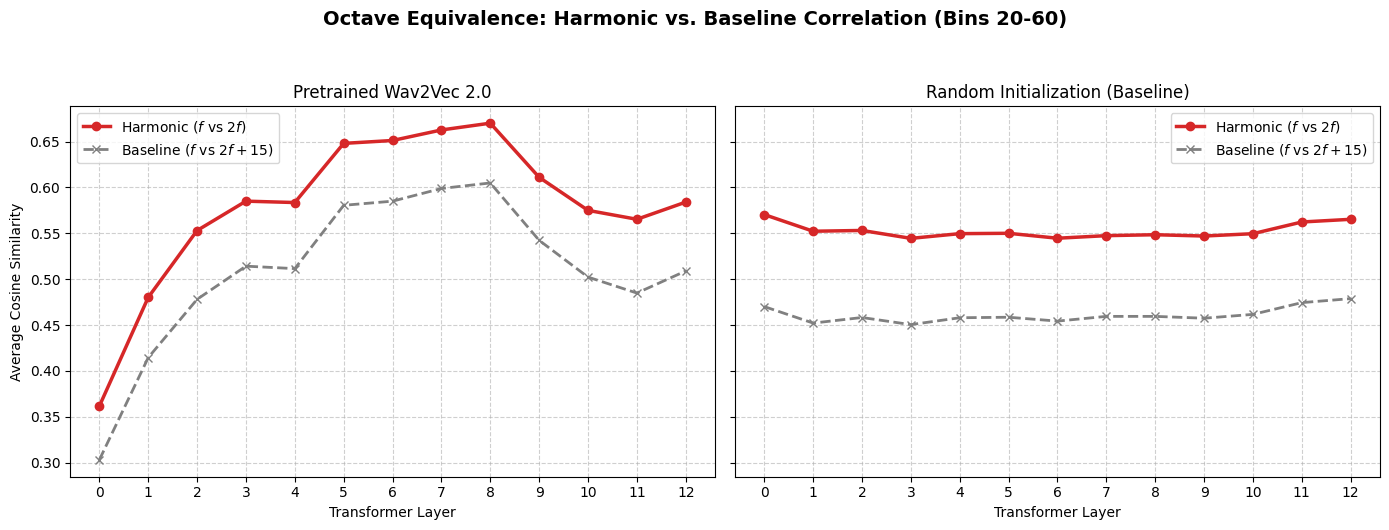

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os

# 1. File paths (Update these if your folder names differ slightly!)
pretrained_path = "../results/wav2vec2-base_pretrained_ridge/stft_weights.npz"

random_path = "../results/wav2vec2-base_random_ridge/stft_weights.npz"

pre_data = np.load(pretrained_path)
rand_data = np.load(random_path)

layers = list(range(13))
# Core human voice formants/harmonics (Bins 20 to 60)
bins_to_test = np.arange(200) 

pre_harmonic_sims, pre_baseline_sims = [], []
rand_harmonic_sims, rand_baseline_sims = [], []

for l in layers:
    # Load probe coefficients
    w_pre = pre_data[f"layer_{l}_coefs"]
    w_rand = rand_data[f"layer_{l}_coefs"]
    
    # Calculate similarity matrices
    sim_pre = cosine_similarity(w_pre)
    sim_rand = cosine_similarity(w_rand)
    
    layer_pre_harm, layer_pre_base = [], []
    layer_rand_harm, layer_rand_base = [], []
    
    for b in bins_to_test:
        harmonic_bin = 2 * b          # The perfect octave (2f)
        baseline_bin = (2 * b) + 15   # A non-harmonic, distant frequency
        
        # Ensure we stay within the 257 STFT bins
        if baseline_bin < sim_pre.shape[0]:
            layer_pre_harm.append(sim_pre[b, harmonic_bin])
            layer_pre_base.append(sim_pre[b, baseline_bin])
            
            layer_rand_harm.append(sim_rand[b, harmonic_bin])
            layer_rand_base.append(sim_rand[b, baseline_bin])
            
    # Average the similarities for this layer
    pre_harmonic_sims.append(np.mean(layer_pre_harm))
    pre_baseline_sims.append(np.mean(layer_pre_base))
    rand_harmonic_sims.append(np.mean(layer_rand_harm))
    rand_baseline_sims.append(np.mean(layer_rand_base))

# --- Plotting the Harmonic Gap ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle("Octave Equivalence: Harmonic vs. Baseline Correlation (Bins 20-60)", fontweight='bold', fontsize=14, y=1.05)

# Pretrained Plot
ax1.plot(layers, pre_harmonic_sims, marker='o', color='tab:red', linewidth=2.5, label='Harmonic ($f$ vs $2f$)')
ax1.plot(layers, pre_baseline_sims, marker='x', color='gray', linestyle='--', linewidth=2, label='Baseline ($f$ vs $2f + 15$)')
ax1.set_title("Pretrained Wav2Vec 2.0")
ax1.set_xlabel("Transformer Layer")
ax1.set_ylabel("Average Cosine Similarity")
ax1.set_xticks(layers)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# Random Init Plot
ax2.plot(layers, rand_harmonic_sims, marker='o', color='tab:red', linewidth=2.5, label='Harmonic ($f$ vs $2f$)')
ax2.plot(layers, rand_baseline_sims, marker='x', color='gray', linestyle='--', linewidth=2, label='Baseline ($f$ vs $2f + 15$)')
ax2.set_title("Random Initialization (Baseline)")
ax2.set_xlabel("Transformer Layer")
ax2.set_xticks(layers)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
import os

# 1. SETUP LABELS AND BINS
n_bins = 257
freqs = np.linspace(0, 8000, n_bins)
freqs[0] = 1.0  # Avoid log(0)

# Map every bin to a "Note Index" (0 to 11) using the MIDI formula
midi_notes = 12 * np.log2(freqs / 440.0) + 69
chroma_indices = np.round(midi_notes) % 12  # 0=C, 1=C#, ..., 11=B
labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# 2. LOAD WEIGHTS
layer_idx = 12

# Update paths if your folders are named differently!
pre_path = "../results/wav2vec2-base_pretrained_ridge/stft_weights.npz"
rand_path = "../results/wav2vec2-base_random_ridge/stft_weights.npz"

pre_data = np.load(pre_path)
rand_data = np.load(rand_path)

W_pre = pre_data[f"layer_{layer_idx}_coefs"]
W_rand = rand_data[f"layer_{layer_idx}_coefs"]

# 3. EXTRACTION FUNCTION
def get_chroma_pca(W_layer):
    chroma_vectors = []
    valid_labels = []
    
    for i in range(12):
        # Find all bins that map to this note
        indices = np.where(chroma_indices == i)[0]
        
        # Filter out very low/high freq noise (keep human voice range 80-4000Hz)
        indices = [idx for idx in indices if 80 < freqs[idx] < 4000]
        
        if len(indices) > 0:
            # Average the weight vectors (Collapsing the Octaves)
            avg_vec = np.mean(W_layer[indices], axis=0)
            chroma_vectors.append(avg_vec)
            valid_labels.append(labels[i])
            
    chroma_vectors = np.array(chroma_vectors)
    
    # Run PCA to get 2D coordinates
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(chroma_vectors)
    return reduced, valid_labels

# Extract for both models
reduced_pre, labels_pre = get_chroma_pca(W_pre)
reduced_rand, labels_rand = get_chroma_pca(W_rand)

# 4. PLOT THE CLOCKS SIDE-BY-SIDE
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=(f"Pretrained Chroma (Layer {layer_idx})", f"Random Chroma (Layer {layer_idx})")
)

# --- Add Pretrained Trace ---
fig.add_trace(go.Scatter(
    x=reduced_pre[:, 0], y=reduced_pre[:, 1],
    mode='markers+text', text=labels_pre, textposition="top center",
    marker=dict(size=15, color=np.arange(len(labels_pre)), colorscale='Rainbow', showscale=False)
), row=1, col=1)

# Connect the Pretrained loop
fig.add_trace(go.Scatter(
    x=np.append(reduced_pre[:, 0], reduced_pre[0, 0]), 
    y=np.append(reduced_pre[:, 1], reduced_pre[0, 1]),
    mode='lines', line=dict(color='gray', dash='dash'), hoverinfo='skip'
), row=1, col=1)

# --- Add Random Trace ---
fig.add_trace(go.Scatter(
    x=reduced_rand[:, 0], y=reduced_rand[:, 1],
    mode='markers+text', text=labels_rand, textposition="top center",
    marker=dict(size=15, color=np.arange(len(labels_rand)), colorscale='Rainbow', showscale=False)
), row=1, col=2)

# Connect the Random loop
fig.add_trace(go.Scatter(
    x=np.append(reduced_rand[:, 0], reduced_rand[0, 0]), 
    y=np.append(reduced_rand[:, 1], reduced_rand[0, 1]),
    mode='lines', line=dict(color='gray', dash='dash'), hoverinfo='skip'
), row=1, col=2)

# 5. CLEANUP LAYOUT
fig.update_layout(
    title=f"The Geometry of Chroma (Layer {layer_idx}) - Collapsed Octaves",
    title_x=0.5, width=1000, height=600, template="plotly_white",
    showlegend=False
)

# Ensure the axes are scaled squarely so circles look like circles
fig.update_xaxes(scaleanchor="y", scaleratio=1, row=1, col=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1, row=1, col=1)
fig.update_xaxes(scaleanchor="y", scaleratio=1, row=1, col=2)
fig.update_yaxes(scaleanchor="x", scaleratio=1, row=1, col=2)

fig.show()

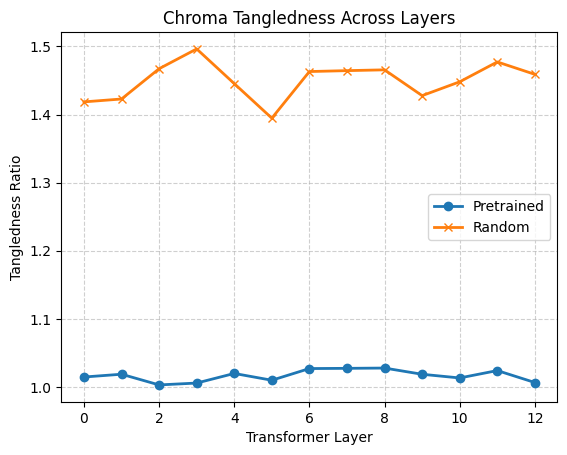

In [149]:
import numpy as np
from scipy.spatial import ConvexHull

def calculate_convexity_ratio(points_2d):
    """
    Calculates the Tangledness of a sequence of 2D points.
    Ratio = 1.0 means a perfectly untangled convex polygon.
    Ratio > 1.0 means the sequence crisscrosses or folds inward.
    """
    n_points = points_2d.shape[0]
    
    # 1. Calculate the Sequential Path Length (C -> C# -> D ... -> C)
    path_length = 0
    for i in range(n_points):
        p1 = points_2d[i]
        p2 = points_2d[(i + 1) % n_points] # Loops back to the start
        path_length += np.linalg.norm(p1 - p2)
        
    # 2. Calculate the Convex Hull Perimeter (The "Rubber Band")
    hull = ConvexHull(points_2d)
    hull_length = 0
    # hull.simplices contains the indices of the line segments forming the hull
    for simplex in hull.simplices:
        p1 = points_2d[simplex[0]]
        p2 = points_2d[simplex[1]]
        hull_length += np.linalg.norm(p1 - p2)
        
    # 3. Calculate the Ratio
    ratio = path_length / hull_length
    return ratio

pres = []
rands = []
for layer_idx in range(13):

    pre_path = "../results/wav2vec2-base_pretrained_ridge/stft_weights.npz"
    rand_path = "../results/wav2vec2-base_random_ridge/stft_weights.npz"

    pre_data = np.load(pre_path)
    rand_data = np.load(rand_path)

    W_pre = pre_data[f"layer_{layer_idx}_coefs"]
    W_rand = rand_data[f"layer_{layer_idx}_coefs"]
    reduced_pre, _ = get_chroma_pca(W_pre)
    reduced_rand, _ = get_chroma_pca(W_rand)
    ratio_pre = calculate_convexity_ratio(reduced_pre)
    ratio_rand = calculate_convexity_ratio(reduced_rand)

    pres.append(ratio_pre)
    rands.append(ratio_rand)

plt.plot(layers, pres, marker='o', label='Pretrained', color='tab:blue', linewidth=2)
plt.plot(layers, rands, marker='x', label='Random', color='tab:orange', linewidth=2)
plt.xlabel("Transformer Layer")
plt.ylabel("Tangledness Ratio")
plt.title("Chroma Tangledness Across Layers")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
